#To start: load dataset and clean

In [0]:
#load data and keep the useful cols
import urllib.request  # the lib that handles the url stuff
import pandas as pd
import base64
target_url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
x = urllib.request.urlopen(target_url) #as http response type
data = x.read().decode('utf-8')        #to byte, then to string
print(data,  file=open('C:con19.txt', 'w'))    #save string file
df = pd.read_csv (r'C:con19.txt')              #load txt file, to csv
df.to_csv (r'C:con19.csv', index=None)
print(df.columns)  

#only keep location,date,total_cases,total_deaths,case per million, death per million as useful cols
df.drop(df.columns[[0,4,6,8,10,11,12,13,14,15]], axis=1, inplace=True)
print('Dataset shape:',df.shape)
df.head()

Index(['iso_code', 'location', 'date', 'total_cases', 'new_cases',
       'total_deaths', 'new_deaths', 'total_cases_per_million',
       'new_cases_per_million', 'total_deaths_per_million',
       'new_deaths_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand', 'tests_units'],
      dtype='object')
Dataset shape: (15756, 6)


,location,date,total_cases,total_deaths,total_cases_per_million,total_deaths_per_million
0,Aruba,2020-03-13,2,0,18.733,0.0
1,Aruba,2020-03-20,4,0,37.465,0.0
2,Aruba,2020-03-24,12,0,112.395,0.0
3,Aruba,2020-03-25,17,0,159.227,0.0
4,Aruba,2020-03-26,19,0,177.959,0.0


In [0]:
# add one column: days (count from dec31)
from datetime import datetime
from datetime import timedelta

df['date']= df['date'].astype('datetime64[ns]')
oldestdate = min(df['date'])
newestdate = max(df['date'])
df['days'] = (df['date'] - oldestdate).dt.days
df.head()

,location,date,total_cases,total_deaths,total_cases_per_million,total_deaths_per_million,days
0,Aruba,2020-03-13,2,0,18.733,0.0,73
1,Aruba,2020-03-20,4,0,37.465,0.0,80
2,Aruba,2020-03-24,12,0,112.395,0.0,84
3,Aruba,2020-03-25,17,0,159.227,0.0,85
4,Aruba,2020-03-26,19,0,177.959,0.0,86


In [0]:
#check null value and drop it

countnull = (df['location'].isnull().values.sum(),df['date'].isnull().values.sum(),df['total_cases'].isnull().values.sum(),df['total_deaths'].isnull().values.sum())
print('Count of null values in each col:(loc,date,totcase,totdeath)=',countnull)
#there isn't any null values
#if there is, drop the row 
if sum(countnull) != 0:
  print('There detected null data: the rows are removed and data file is updated.')
  df = df.dropna(axis=0)
print('Dataset shape:',df.shape)
df.to_csv(r'211countrydata.csv', index = False)
numdate = df['date'].nunique()
numcountry = df['location'].nunique()
print("The cleaned dataset gives total cases and deaths confirmed during  {} days in {} countries.".format(numdate,numcountry))
print("The records are from {} to {}".format(oldestdate,newestdate))

Count of null values in each col:(loc,date,totcase,totdeath)= (0, 0, 0, 0)
Dataset shape: (15756, 7)
The cleaned dataset gives total cases and deaths confirmed during  129 days in 211 countries.
The records are from 2019-12-31 00:00:00 to 2020-05-07 00:00:00


In [0]:
#filter to pick five counties with most cases(online search)
selected_country = ['Spain','United States','Italy','United Kingdom','Germany']
df_five = df[df.location.isin(selected_country)]
df_five.to_csv(r'fivecountrydata.csv', index = False)
df_five.head()


,location,date,total_cases,total_deaths,total_cases_per_million,total_deaths_per_million,days
3610,Germany,2019-12-31,0,0,0.0,0.0,0
3611,Germany,2020-01-01,0,0,0.0,0.0,1
3612,Germany,2020-01-02,0,0,0.0,0.0,2
3613,Germany,2020-01-03,0,0,0.0,0.0,3
3614,Germany,2020-01-04,0,0,0.0,0.0,4


# Basic Analysis of Cov19

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



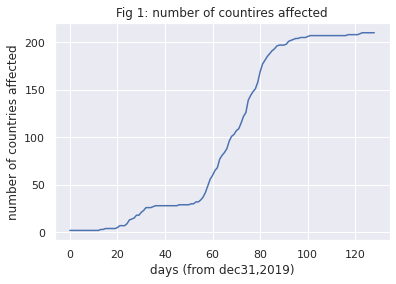

In [0]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns; sns.set()
import numpy as np


# Fig 1: count of affected countries 

x= range(numdate)
y= []  #count of affected countries
c= []  #list of affected countries
for day in x:
  affected_df = df[df['days'] == day]
  affected_df = affected_df[affected_df['total_cases']!=0]  #the df of data on selected date and has total_cases recorded
  c=set(affected_df['location'].unique()).union(set(c)) #add countries who has already affected: avoid effects of missing data
  y.append(len(c))
plt.xlabel('days (from dec31,2019)')
plt.ylabel('number of countries affected')
plt.title('Fig 1: number of countires affected')
plt.plot(x,y)
plt.show()

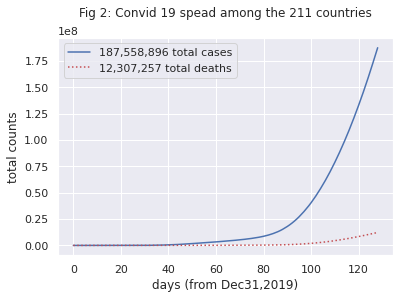

In [0]:
# Fig 2: total cases and deaths

x= range(numdate)
y1= []  #sum of cases
y2= []  #sum of deaths
sum1 = 0
sum2 = 0

for day in x:
  affected_df = df[df['days'] == day]
  sum1 = sum1 + sum(affected_df['total_cases'])  
  sum2 = sum2 + sum(affected_df['total_deaths'])
  y1.append(sum1)
  y2.append(sum2)


plt.xlabel('days (from Dec31,2019)')
plt.ylabel('total counts')
plt.title('Fig 2: Convid 19 spead among the 211 countries\n')

plt.plot(x, y1, 'b-',label ='{} total cases'.format(f"{y1[-1]:,}"))
plt.plot(x, y2,'r:',label = '{} total deaths'.format(f"{y2[-1]:,}"))
plt.legend()
plt.show()


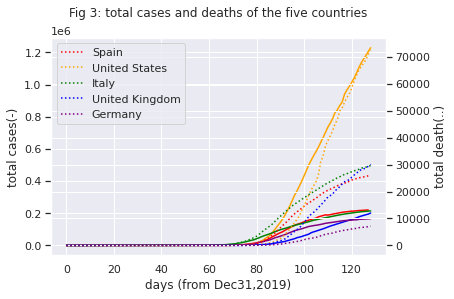

In [0]:

# Fig 3: scatter plot of the five countries
fig3, ax1 = plt.subplots()
ax1.set_xlabel('days (from Dec31,2019)')
ax1.set_ylabel('total cases(-)')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('total death(..)')  # we already handled the x-label with ax1
plt.title('Fig 3: total cases and deaths of the five countries\n')

colors = ['red','orange','green','blue','purple']
for i in range(len(selected_country)):
  df_i = df_five[df_five['location'] == selected_country[i]] #data of a country
  x= df_i['days']
  y1=df_i['total_cases']
  y2=df_i['total_deaths']
  ax1.plot(x, y1, color = colors[i])
  ax2.plot(x, y2,':',color = colors[i],label = selected_country[i])
  plt.legend()

#fig3.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [0]:
#cluster

In [0]:
#PCA

In [0]:
#classification

In [0]:
#linear prediction

In [0]:
#relationship between conv19 and economics(lack of data)